In [1]:
import pandas as pd
import numpy as np

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [103]:
class Data:
    def __init__(self, path: str) -> None:    
        demand_path = path + "/Demand_history.csv"
        existingEV_path = path + "/existing_EV_infrastructure_2018.csv"
        self.df_orig = pd.read_csv(demand_path)
        self.df_trans = self.df_orig
        self.years_window = 2
        self.y_cols = [f"n-{y}" for y in range(1, self.years_window + 1)]
        
    def clean(self):
        self.df_orig.loc[(self.df_orig != 0).any(1)]
        print(self.df_orig)
        
    def split(self):
        
        x_train = pd.DataFrame(columns=["x_coordinate", "y_coordinate", *self.y_cols])
        x_test = pd.DataFrame(columns=["x_coordinate", "y_coordinate", *self.y_cols])
        y_train = pd.Series(dtype=np.float64)
        y_test = pd.Series(dtype=np.float64)
        for y in self.df_trans.columns[self.df_trans.columns.str.startswith('20')]:
            y = int(y)
            if y < 2010 + self.years_window:
                continue
            y_cols = [f"{y - i}" for i in range(1, self.years_window + 1)]
            stack_x = self.df_trans.loc[:, self.df_trans.columns.isin(["x_coordinate", "y_coordinate", *y_cols])]
            y_dict = {f"{y - i}": f"n-{i}" for i in range(1, self.years_window + 1)}
            stack_x = stack_x.rename(columns=y_dict)
            stack_y = self.df_trans.loc[:, f"{y}"]
            if y == 2018:
                 x_test = pd.concat([x_test, stack_x], axis=0, ignore_index=True)
                 y_test = pd.concat([y_test, stack_y], axis=0, ignore_index=True)
            else:
                x_train = pd.concat([x_train, stack_x], axis=0, ignore_index=True)
                y_train = pd.concat([y_train, stack_y], axis=0, ignore_index=True)
        
        data.x_train = x_train
        data.x_test = x_test
        data.y_train = y_train
        data.y_test = y_test
        
    def addYearDemandfromForecast(self, year: int, predicted: np.array) -> None:
        predicted = predicted.reshape(-1, 1)
        self.df_trans[f"{year}"] = predicted        
                  
path = "data"
data = Data(path)
data.split()

In [104]:
data.x_train

,x_coordinate,y_coordinate,n-1
0,0.5,0.5,0.352242
1,1.5,0.5,0.325940
2,2.5,0.5,0.373752
3,3.5,0.5,0.420686
4,4.5,0.5,0.475621
...,...,...,...
28667,59.5,63.5,3.352280
28668,60.5,63.5,1.107797
28669,61.5,63.5,1.822806
28670,62.5,63.5,4.494515


In [105]:
class Model:
    def __init__(self, data: Data) -> None:
        self.data = data
        self.model = xgb.XGBRegressor()
    
    def feature_importance(self) -> None:
        _ = xgb.plot_importance(self.model, height=0.9)
    
    def fit(self) -> None:
        self.model.fit(data.x_train, data.y_train,
            eval_set=[(data.x_train, data.y_train), (data.x_test, data.y_test)],
            early_stopping_rounds=10)
        
        pred = self.model.predict(data.x_train)
        train_rmse = np.sqrt(mean_squared_error(data.y_train, pred))
        train_mae = mean_absolute_error(data.y_train, pred)   
        train_r2 = r2_score(data.y_train, pred) 
        pred = self.model.predict(data.x_test)
        test_rmse = np.sqrt(mean_squared_error(data.y_test, pred))
        test_mae = mean_absolute_error(data.y_test, pred)   
        test_r2 = r2_score(data.y_test, pred)    
        
        print(f"training: rmse={train_rmse}, mae={train_mae}, r2={train_r2}")   
        print(f"test: rmse={test_rmse}, mae={test_mae}, r2={test_r2}")                        
    
    def predict(self, year: int) -> pd.Series:
        y_cols = [f"{year - i}" for i in range(1, data.years_window + 1)]
        x_forecast = \
            data.df_trans.loc[:,
                              data.df_trans.columns.isin(["x_coordinate", "y_coordinate", *y_cols])]        
        return self.model.predict(x_forecast)
    
    def set_params(self, params):
        params['n_estimators'] = int(params['n_estimators'])
        params['max_depth'] = int(params['max_depth'])
        self.model.set_params(**params)
        

In [106]:
model = Model(data)

In [107]:
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform("n_estimators", 100, 1000, 10),
        'seed': 0,
        'objective': 'reg:squarederror'
    }

def objective(space):
    model.set_params(space)
    
    evaluation = [(data.x_train, data.y_train), (data.x_test, data.y_test)]
    
    model.model.fit(data.x_train, data.y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10, verbose=False)
    

    pred = model.model.predict(data.x_test)
    rmse = np.sqrt(mean_squared_error(data.y_test, pred))
    print ("rmse:", rmse)
    return {'loss': rmse, 'status': STATUS_OK }

In [108]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                  
15.841692106141013                                     
  1%|          | 1/100 [00:00<00:43,  2.26trial/s, best loss: 15.841692106141013]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                            
15.746384012193106                                                               
  2%|▏         | 2/100 [00:00<00:34,  2.82trial/s, best loss: 15.746384012193106]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                            
15.904406447488215                                                               
  3%|▎         | 3/100 [00:01<00:33,  2.90trial/s, best loss: 15.746384012193106]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                            
16.21791808064095                                                                
  4%|▍         | 4/100 [00:01<00:35,  2.74trial/s, best loss: 15.746384012193106]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                            
15.648201898355326                                                               
  5%|▌         | 5/100 [00:01<00:34,  2.73trial/s, best loss: 15.648201898355326]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                            
15.641516385185332                                                               
rmse:                                                                            
15.615903373425754                                                               
  7%|▋         | 7/100 [00:02<00:27,  3.44trial/s, best loss: 15.615903373425754]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                            
15.567041449327961                                                               
  8%|▊         | 8/100 [00:02<00:26,  3.43trial/s, best loss: 15.567041449327961]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                            
15.802953660287894                                                               
  9%|▉         | 9/100 [00:02<00:27,  3.31trial/s, best loss: 15.567041449327961]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                            
15.77959658176495                                                                
 10%|█         | 10/100 [00:03<00:28,  3.19trial/s, best loss: 15.567041449327961]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.672258121760736                                                                
 11%|█         | 11/100 [00:03<00:33,  2.64trial/s, best loss: 15.567041449327961]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.926316254881689                                                                
 12%|█▏        | 12/100 [00:04<00:31,  2.75trial/s, best loss: 15.567041449327961]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.949195594308732                                                                
 13%|█▎        | 13/100 [00:04<00:34,  2.54trial/s, best loss: 15.567041449327961]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.795630990748348                                                                
rmse:                                                                             
15.614258575937816                                                                
 15%|█▌        | 15/100 [00:05<00:25,  3.30trial/s, best loss: 15.567041449327961]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.645890536460328                                                                
 16%|█▌        | 16/100 [00:05<00:27,  3.03trial/s, best loss: 15.567041449327961]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.940101246916528                                                                
 17%|█▋        | 17/100 [00:05<00:28,  2.95trial/s, best loss: 15.567041449327961]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.758833430584795                                                                
 18%|█▊        | 18/100 [00:06<00:28,  2.93trial/s, best loss: 15.567041449327961]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.567620305285464                                                                
rmse:                                                                             
15.86269577657283                                                                 
 20%|██        | 20/100 [00:06<00:24,  3.30trial/s, best loss: 15.567041449327961]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.643782285989463                                                                
 21%|██        | 21/100 [00:07<00:24,  3.27trial/s, best loss: 15.567041449327961]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.896377118062098                                                                
rmse:                                                                             
15.88887505845799                                                                 
 23%|██▎       | 23/100 [00:07<00:21,  3.60trial/s, best loss: 15.567041449327961]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.693190134452761                                                                
 24%|██▍       | 24/100 [00:07<00:20,  3.70trial/s, best loss: 15.567041449327961]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.535186245946411                                                                
 25%|██▌       | 25/100 [00:08<00:22,  3.32trial/s, best loss: 15.535186245946411]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.669859003005381                                                                
 26%|██▌       | 26/100 [00:08<00:25,  2.85trial/s, best loss: 15.535186245946411]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.421603228467353                                                                
 27%|██▋       | 27/100 [00:09<00:26,  2.71trial/s, best loss: 15.421603228467353]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.530917753640576                                                                
 28%|██▊       | 28/100 [00:09<00:26,  2.68trial/s, best loss: 15.421603228467353]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
16.035193915992885                                                                
 29%|██▉       | 29/100 [00:09<00:26,  2.73trial/s, best loss: 15.421603228467353]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.475020335765258                                                                
 30%|███       | 30/100 [00:10<00:26,  2.60trial/s, best loss: 15.421603228467353]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
16.01085336997214                                                                 
 31%|███       | 31/100 [00:10<00:26,  2.58trial/s, best loss: 15.421603228467353]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.416963553182793                                                                
 32%|███▏      | 32/100 [00:11<00:27,  2.51trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.961855592163845                                                                
 33%|███▎      | 33/100 [00:11<00:25,  2.61trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
16.249757931728563                                                                
 34%|███▍      | 34/100 [00:11<00:25,  2.56trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.811163106599928                                                                
 35%|███▌      | 35/100 [00:12<00:24,  2.61trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.928190579629586                                                                
 36%|███▌      | 36/100 [00:12<00:24,  2.62trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.934727222680932                                                                
 37%|███▋      | 37/100 [00:12<00:24,  2.60trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.661153014507494                                                                
 38%|███▊      | 38/100 [00:13<00:24,  2.58trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.954370908821527                                                                
 39%|███▉      | 39/100 [00:13<00:25,  2.39trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.943418851992883                                                                
 40%|████      | 40/100 [00:14<00:24,  2.45trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.793668907974618                                                                
 41%|████      | 41/100 [00:14<00:23,  2.56trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.990471427084918                                                                
 42%|████▏     | 42/100 [00:14<00:23,  2.47trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.841032838511953                                                                
 43%|████▎     | 43/100 [00:15<00:21,  2.65trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.652038306145569                                                                
 44%|████▍     | 44/100 [00:15<00:21,  2.66trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.999851237621325                                                                
 45%|████▌     | 45/100 [00:16<00:20,  2.74trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.984896530688493                                                                
 46%|████▌     | 46/100 [00:16<00:18,  2.91trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.837217118286848                                                                
 47%|████▋     | 47/100 [00:16<00:17,  3.03trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
16.01299805476338                                                                 
 48%|████▊     | 48/100 [00:16<00:17,  2.95trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.70721366819694                                                                 
 49%|████▉     | 49/100 [00:17<00:15,  3.26trial/s, best loss: 15.416963553182793]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.408605256382648                                                                
 50%|█████     | 50/100 [00:17<00:18,  2.76trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.422110211864544                                                                
 51%|█████     | 51/100 [00:18<00:17,  2.84trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.602581521489919                                                                
rmse:                                                                             
15.805861073059216                                                                
 53%|█████▎    | 53/100 [00:18<00:15,  3.06trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.899042730773163                                                                
 54%|█████▍    | 54/100 [00:19<00:15,  3.04trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.928631049931326                                                                
 55%|█████▌    | 55/100 [00:19<00:16,  2.81trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.425884637033885                                                                
 56%|█████▌    | 56/100 [00:19<00:17,  2.58trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
16.181618664535133                                                                
 57%|█████▋    | 57/100 [00:20<00:15,  2.82trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.765393927429391                                                                
 58%|█████▊    | 58/100 [00:20<00:16,  2.51trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.941431848307293                                                                
 59%|█████▉    | 59/100 [00:21<00:16,  2.56trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.813012268405695                                                                
 60%|██████    | 60/100 [00:21<00:15,  2.62trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.814225901453591                                                                
 61%|██████    | 61/100 [00:21<00:15,  2.49trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.61740618359172                                                                 
 62%|██████▏   | 62/100 [00:22<00:14,  2.70trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.83643819964782                                                                 
 63%|██████▎   | 63/100 [00:22<00:12,  3.05trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
16.152025349414487                                                                
 64%|██████▍   | 64/100 [00:22<00:11,  3.01trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.429926113216895                                                                
 65%|██████▌   | 65/100 [00:23<00:12,  2.79trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.422359951565085                                                                
 66%|██████▌   | 66/100 [00:23<00:13,  2.57trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.539528071125845                                                                
 67%|██████▋   | 67/100 [00:24<00:13,  2.54trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.527475602649702                                                                
 68%|██████▊   | 68/100 [00:24<00:12,  2.48trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.528980487852033                                                                
 69%|██████▉   | 69/100 [00:24<00:12,  2.47trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.416312501502318                                                                
 70%|███████   | 70/100 [00:25<00:12,  2.45trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
16.040729968129703                                                                
 71%|███████   | 71/100 [00:25<00:11,  2.59trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.529871402445169                                                                
 72%|███████▏  | 72/100 [00:26<00:11,  2.52trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.838970840924196                                                                
 73%|███████▎  | 73/100 [00:26<00:10,  2.65trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.60563885987801                                                                 
 74%|███████▍  | 74/100 [00:26<00:09,  2.78trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.667021472636742                                                                
 75%|███████▌  | 75/100 [00:26<00:08,  2.88trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.83729092798795                                                                 
 76%|███████▌  | 76/100 [00:27<00:08,  2.83trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.777050365239917                                                                
 77%|███████▋  | 77/100 [00:27<00:07,  2.89trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.66669899924753                                                                 
 78%|███████▊  | 78/100 [00:28<00:07,  2.86trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.424703014089715                                                                
 79%|███████▉  | 79/100 [00:28<00:07,  2.88trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.889442552133842                                                                
 80%|████████  | 80/100 [00:28<00:07,  2.71trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.882866103735733                                                                
 81%|████████  | 81/100 [00:29<00:07,  2.70trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.8034083858015                                                                  
 82%|████████▏ | 82/100 [00:29<00:06,  2.60trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.602529109563822                                                                
 83%|████████▎ | 83/100 [00:29<00:06,  2.59trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.776070209196993                                                                
 84%|████████▍ | 84/100 [00:30<00:05,  2.96trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.529120589298705                                                                
 85%|████████▌ | 85/100 [00:30<00:06,  2.44trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.668258567187234                                                                
 86%|████████▌ | 86/100 [00:31<00:05,  2.59trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.602879026213959                                                                
 87%|████████▋ | 87/100 [00:31<00:05,  2.55trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.624882106876921                                                                
 88%|████████▊ | 88/100 [00:31<00:04,  2.60trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.998526279736769                                                                
 89%|████████▉ | 89/100 [00:32<00:04,  2.45trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.885034086501564                                                                
 90%|█████████ | 90/100 [00:32<00:03,  2.62trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.621802516242019                                                                
 91%|█████████ | 91/100 [00:33<00:03,  2.65trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.65135560174172                                                                 
 92%|█████████▏| 92/100 [00:33<00:03,  2.54trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.910653649794654                                                                
 93%|█████████▎| 93/100 [00:33<00:02,  2.54trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.948128974974178                                                                
 94%|█████████▍| 94/100 [00:34<00:02,  2.46trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.928163104438346                                                                
 95%|█████████▌| 95/100 [00:34<00:02,  2.42trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.783964891293609                                                                
 96%|█████████▌| 96/100 [00:35<00:01,  2.66trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.647199174138581                                                                
 97%|█████████▋| 97/100 [00:35<00:01,  2.66trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.957798513639176                                                                
 98%|█████████▊| 98/100 [00:35<00:00,  2.50trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.827320090161539                                                                
 99%|█████████▉| 99/100 [00:36<00:00,  2.48trial/s, best loss: 15.408605256382648]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



rmse:                                                                             
15.429230891214036                                                                
100%|██████████| 100/100 [00:36<00:00,  2.73trial/s, best loss: 15.408605256382648]


In [109]:
print("The best hyperparameters are : ","\n")
best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
print(best_hyperparams)


The best hyperparameters are :  

{'colsample_bytree': 0.6401470231767599, 'gamma': 7.959467302975132, 'max_depth': 12, 'min_child_weight': 9.0, 'n_estimators': 450, 'reg_alpha': 50.0, 'reg_lambda': 0.5227907956383473}


[0]	validation_0-rmse:52.01484	validation_1-rmse:109.10146
[1]	validation_0-rmse:37.07753	validation_1-rmse:74.70134
[2]	validation_0-rmse:34.68745	validation_1-rmse:70.46449
[3]	validation_0-rmse:25.42911	validation_1-rmse:48.51387
[4]	validation_0-rmse:19.30131	validation_1-rmse:32.40307
[5]	validation_0-rmse:18.86318	validation_1-rmse:31.30388
[6]	validation_0-rmse:17.92903	validation_1-rmse:29.69256
[7]	validation_0-rmse:17.45047	validation_1-rmse:28.63880
[8]	validation_0-rmse:17.21063	validation_1-rmse:27.93807
[9]	validation_0-rmse:14.07994	validation_1-rmse:20.37596
[10]	validation_0-rmse:14.03256	validation_1-rmse:20.14033
[11]	validation_0-rmse:13.99213	validation_1-rmse:20.06535
[12]	validation_0-rmse:13.97224	validation_1-rmse:19.93894
[13]	validation_0-rmse:13.96230	validation_1-rmse:19.85168
[14]	validation_0-rmse:12.17256	validation_1-rmse:16.41659
[15]	validation_0-rmse:12.10465	validation_1-rmse:16.36371
[16]	validation_0-rmse:12.10100	validation_1-rmse:16.35974
[17]	v

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19]	validation_0-rmse:12.06479	validation_1-rmse:16.33811
[20]	validation_0-rmse:12.04795	validation_1-rmse:16.33135
[21]	validation_0-rmse:12.04753	validation_1-rmse:16.33326
[22]	validation_0-rmse:10.90249	validation_1-rmse:15.40861
[23]	validation_0-rmse:10.27850	validation_1-rmse:16.00976
[24]	validation_0-rmse:10.24435	validation_1-rmse:15.96146
[25]	validation_0-rmse:9.89984	validation_1-rmse:16.98433
[26]	validation_0-rmse:9.69539	validation_1-rmse:17.93037
[27]	validation_0-rmse:9.53726	validation_1-rmse:17.67362
[28]	validation_0-rmse:9.45856	validation_1-rmse:17.51150
[29]	validation_0-rmse:9.41925	validation_1-rmse:17.40506
[30]	validation_0-rmse:9.24917	validation_1-rmse:18.30827
[31]	validation_0-rmse:9.13027	validation_1-rmse:19.25296
[32]	validation_0-rmse:9.08297	validation_1-rmse:19.12684
training: rmse=10.902493891698445, mae=7.764347081039885, r2=0.9486552500042346
test: rmse=15.408605256382648, mae=11.49847744530691, r2=0.9624381679536852


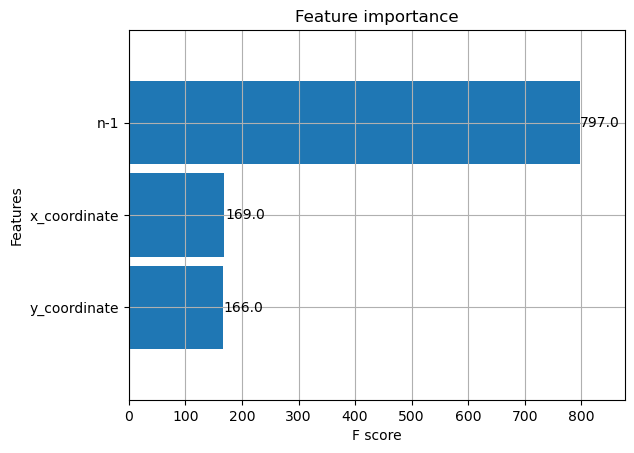

In [110]:
model.set_params(best_hyperparams)
model.fit()
model.feature_importance()

In [111]:
predicted_2019 = model.predict(2019)

In [112]:
data.addYearDemandfromForecast(2019, predicted_2019)

In [113]:
data.df_trans

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572,7.794302
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091,6.017729
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254,11.484052
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302,12.517267
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563,13.441733
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,59.5,63.5,0.171015,0.334565,0.556055,1.373291,1.837586,2.517146,3.352280,4.149888,5.426193,-1.641063
4092,4092,60.5,63.5,0.041716,0.061741,0.131291,0.386540,0.755846,0.941116,1.107797,1.309479,2.057450,-7.499731
4093,4093,61.5,63.5,0.100895,0.180352,0.296299,0.705373,1.300220,1.608609,1.822806,2.333681,3.218519,-10.658572
4094,4094,62.5,63.5,0.155353,0.290825,0.557803,1.516066,2.399426,2.719197,4.494515,6.096858,6.262574,-5.253195


In [90]:
predicted_2020 = model.predict(2020)

In [91]:
data.addYearDemandfromForecast(2020, predicted_2020)

In [92]:
data.df_trans

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572,14.228975,16.717131
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091,13.298387,16.717131
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254,13.298387,16.717131
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302,13.298387,17.520485
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563,13.716234,16.717131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,59.5,63.5,0.171015,0.334565,0.556055,1.373291,1.837586,2.517146,3.352280,4.149888,5.426193,22.965816,29.820332
4092,4092,60.5,63.5,0.041716,0.061741,0.131291,0.386540,0.755846,0.941116,1.107797,1.309479,2.057450,3.268945,11.236215
4093,4093,61.5,63.5,0.100895,0.180352,0.296299,0.705373,1.300220,1.608609,1.822806,2.333681,3.218519,11.744149,29.681217
4094,4094,62.5,63.5,0.155353,0.290825,0.557803,1.516066,2.399426,2.719197,4.494515,6.096858,6.262574,22.965816,30.563858


In [93]:
data.df_trans.to_csv("data/forecast.csv")